#### StandardNet experiments ####
This notebook was used to perform the StandardNet experiments.

In [ ]:
# some necessary imports and setting seed

import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from pytorch_revgrad import RevGrad
import random
import torch.nn as nn
import torch.nn.functional as F
import model
import tt_standardnet as stn
import visualization as vis


torch.manual_seed(0)

In [2]:
# loading in (and if necessary downloading) the MNIST and USPS datasets

transformation = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomCrop((28, 28)),
    transforms.ToTensor()
])

train_MNIST = datasets.MNIST('', train=True, download=True, transform=transformation)
test_MNIST = datasets.MNIST('', train=False, download=True, transform=transformation)

train_USPS = datasets.USPS('USPS', train=True, download=True, transform=transformation)
test_USPS = datasets.USPS('USPS', train=False, download=True, transform=transformation)

trainset_MNIST = torch.utils.data.DataLoader(train_MNIST, batch_size=32, shuffle=True)
testset_MNIST = torch.utils.data.DataLoader(test_MNIST, batch_size=32, shuffle=False)

trainset_USPS = torch.utils.data.DataLoader(train_USPS, batch_size=32, shuffle=True)
testset_USPS = torch.utils.data.DataLoader(test_USPS, batch_size=32, shuffle=False)

In [3]:
# if available setting the device to GPU

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [4]:
source = "USPS"
target = "MNIST"

In [9]:
# setting training parameters (these exact parameters were not used in the report experiments, number of epochs used for report = 200)

if source == "MNIST":
    num_epochs = 10
    source_train = trainset_MNIST
    target_train = trainset_USPS
    source_test = testset_MNIST
    target_test = testset_USPS
    
elif source == "USPS":
    num_epochs = 10
    source_train = trainset_USPS
    target_train = trainset_MNIST
    source_test = testset_USPS
    target_test = testset_MNIST
    
gamma_reg = 0.01
lambda_loss = [0.0, 0.5, 0.9]

In [10]:
max_target_PCA_accs = torch.zeros(len(lambda_loss))
optimal_standardnets = []

count = 0
for lambda_l in lambda_loss:

    print("lambda_loss : % 5.1f" %(lambda_l))

    standardnet = model.StandardNet().to(device)
    optimizer_standardnet = torch.optim.Adam(standardnet.parameters(), lr=1e-3)

    [optimal_standardnet, max_target_PCA_accuracy] = stn.train_standardnet(device, standardnet, optimizer_standardnet, lambda_l, num_epochs, trainset_MNIST, trainset_USPS, testset_MNIST, testset_USPS)
    optimal_standardnets.append(optimal_standardnet)
    max_target_PCA_accs[count] = max_target_PCA_accuracy
    
    count += 1

lambda_loss :   0.0
Epoch :  0, Average loss :  0.44, PCA accuracy :  0.76
Epoch :  1, Average loss :  0.16, PCA accuracy :  0.76
Epoch :  2, Average loss :  0.13, PCA accuracy :  0.81
Epoch :  3, Average loss :  0.10, PCA accuracy :  0.79
Epoch :  4, Average loss :  0.10, PCA accuracy :  0.81
Epoch :  5, Average loss :  0.10, PCA accuracy :  0.77
Epoch :  6, Average loss :  0.08, PCA accuracy :  0.83
Epoch :  7, Average loss :  0.08, PCA accuracy :  0.83
Epoch :  8, Average loss :  0.06, PCA accuracy :  0.71
Epoch :  9, Average loss :  0.07, PCA accuracy :  0.85
lambda_loss :   0.5
Epoch :  0, Average loss :  1.20, PCA accuracy :  0.67
Epoch :  1, Average loss :  0.27, PCA accuracy :  0.72
Epoch :  2, Average loss :  0.17, PCA accuracy :  0.75
Epoch :  3, Average loss :  0.13, PCA accuracy :  0.80
Epoch :  4, Average loss :  0.12, PCA accuracy :  0.76
Epoch :  5, Average loss :  0.12, PCA accuracy :  0.78
Epoch :  6, Average loss :  0.10, PCA accuracy :  0.79
Epoch :  7, Average loss 

In [11]:
# possibility to save and load results

save = False 
if save == True:
    torch.save(max_target_PCA_accs, 'StandardNet_max_target_PCA_accs')
    torch.save(optimal_standardnets, 'optimal_standardnets')
    
load = False
if load == True:
    max_target_PCA_accs = torch.load('StandardNet_max_target_PCA_accs')
    optimal_standardnets =  torch.load('optimal_standardnets')

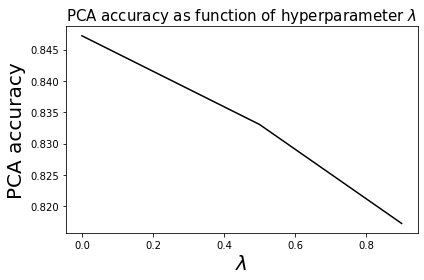

tensor([0.8472, 0.8331, 0.8173])


In [12]:
# visualize PCA accuracy as function of hyperparameter lambda 

if len(lambda_loss) > 1:
    vis.show_PCA_lambda(lambda_loss, max_target_PCA_accs, save=False)
    
print(max_target_PCA_accs)

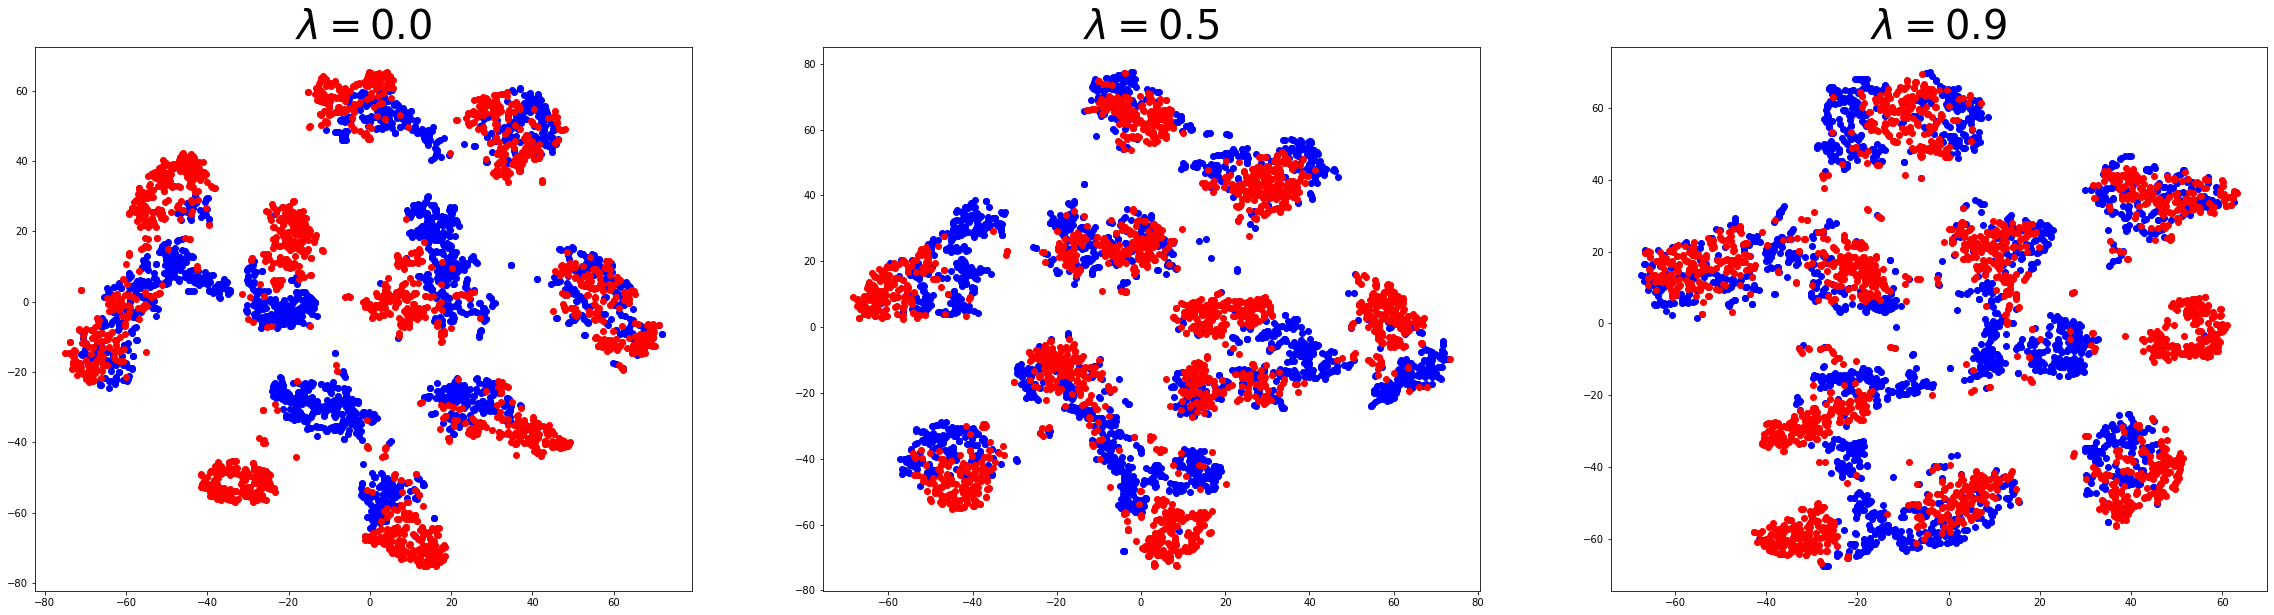

In [13]:
if len(lambda_loss) > 1:
    interesting_ids = [0, 1, 2] # manually input the indices of the interesting points of the above figure to show t-SNE reduced feature representations
else:
    interesting_ids = [0] # if only one model is trained 

optimal_standardnet_encoders = []
for optimal_standardnet in optimal_standardnets:
    optimal_standardnet_encoders.append(optimal_standardnet.encoder)

vis.show_reduced_features(device, optimal_standardnet_encoders, interesting_ids, lambda_loss, source_train, target_train) # calculating this takes some time